# Plan thực hiện
# Mô tả dữ liệu: 
- mỗi d_123 là một document 
# Cấu trúc lưu trữ để dể tính toán cho các bước sau:
# Luồng thực hiện
- Xử lý dữ liệu văn bản từ file cô cho thành dạng: { doc_id, num, wd_count, sentence }

In [1]:
%pip install pd numpy nltk


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import re

class DocReader:
    '''
    Tiền xử lý dữ liệu
    Biến đỗi các từ trong tập dữ liệu DUC sang CSV để tiện xử lý. ở các bước tiếp theo
    '''
    def __init__(self, file_name):
        self.file_name = file_name

    def parse_sentence(self, line):
        match = re.match(r'<s docid="([^"]+)" num="(\d+)" wdcount="(\d+)"> (.*)</s>', line)
        if match:
            return {
                'docid': match.group(1),
                'num': int(match.group(2)),
                'wdcount': int(match.group(3)),
                'sentence': match.group(4)
            }
        return None

    def to_df(self):
        '''
        Duyệt tất các file trong thư mục data - sau đó parse senctence.
        Dữ liệu sẽ được lưu vào DataFrame
        '''
        data = []
        file_path = os.path.join(self.file_name)
        if os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    if line.startswith('<s docid='):
                        parsed = self.parse_sentence(line)
                        if parsed:
                            data.append(parsed)

        return pd.DataFrame(data)

# reader = DocReader('/workspaces/py_env_research/NLP/DUC_TEXT/train/d061j')
# result = reader.to_df()
# result.head()


In [3]:
class TextPreProcessing:
    def __init__(self, sentences):
        self.sentences = sentences

    def clean_text(self):
        cleaned_sentences = [re.sub(r'[^\w\s]', '', sentence) for sentence in self.sentences]
        return cleaned_sentences

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity

class SimilarityProcess:
  def __init__(self, sentences):
    self.sentences = sentences
    self.tf_idf_matrix = None
    self.init_tf_idf()
    
  def init_tf_idf(self):
    vectorizer = TfidfVectorizer()
    self.tf_idf_matrix = vectorizer.fit_transform(self.sentences)
  
  def sim(self, doc_index_1, doc_index_2):
    vector_doc_1 = self.tf_idf_matrix[doc_index_1]
    vector_doc_2 = self.tf_idf_matrix[doc_index_2]
    
    cosine_sim = euclidean_distances(vector_doc_1, vector_doc_2)
    
    return cosine_sim[0][0]
# sentences = [
#   "wondered why the President of the Un",
#   "wondered why the President of the Un",
#   "committee that President Bush's transition.",
#   "which Senate committees may assess presidential nominees"
# ]

# sim_proc = SimilarityProcess(sentences)
# sim = sim_proc.sim(0, 1)
# print("Cosine Similarity between doc 0 and doc 1:", sim)


# Algorithm: PageRank for Undirected Graph
1. Chuyen matran thanh matran kieu numpy de thuc hien cac buoc tinh toan de dang hon như shape, sum,....
2. Tim bac cua tung node.
4. Luu y:
- Co mot so cong thuc no dung ma tran chuyen vi graph.T may cai do dung cho do thi co huong thoi:
  + Vi sao?
5. Tai sao?
  - numpy.dot? Thay vi loop de kiem tra dieu kien - dinh co lien ket voi dinh khac de tinh pr - khi ham nay se nhan 2 ma tran lai voi nhau - cai nao co chi so (1) thi co value, cai nao khogn co chi so (0) thi khong co value
  - dot([[0, 1, 0],[1, 0, 1],[0, 1, 0]], [[0, 1/2, 0],[1/3, 0, 1/2],[0, 1/2, 0]])
  

In [5]:

'''
  Phần này là tính toan PageRank cho ma trận kề đã tạo ở bước trước.
  - Sử dụng ma trận kề đã tạo để tính toan PageRank.
  - Kết quả là ma trận PageRank cho từng node trong ma trận kề.
  - Test voi vi du cua cô trên lớp.
  NOTe:
  -
'''
class PageRankAlgorithm:
    def __init__(self, undirected_graph, damping_factor=0.85, max_loop=30, delta=1e-4):
      self.undirected_graph = undirected_graph
      self.damping_factor = damping_factor
      self.max_loop = max_loop
      self.delta = delta

    def compute(self):
      import numpy 
      undirected_graph = numpy.array(self.undirected_graph, dtype=float)

      total_node = undirected_graph.shape[0]
      degree_of_node = undirected_graph.sum(axis=1)
      
      base_matrix = numpy.ones(total_node)
      # [[1,1,1,1]]
      degree_of_node[degree_of_node == 0] = 1 # To avoid division by zero :)
      
      for _ in range(self.max_loop):
        new_page_rank_matrix = self.damping_factor * numpy.dot(undirected_graph, base_matrix/degree_of_node) + (1 - self.damping_factor) / total_node
        if sum(abs(new_page_rank_matrix - base_matrix)) < self.delta:
          break
        base_matrix = new_page_rank_matrix

      return base_matrix

# Example usage:
# data = [
#   [0, 1, 1, 1, 1, 0],
#   [1, 0, 1, 1, 1, 0],
#   [1, 1, 0, 1, 0, 0],
#   [1, 1, 1, 0, 0, 1],
#   [1, 1, 0, 0, 0, 1],
#   [0, 0, 0, 1, 1, 0]
# ]

# pg = PageRankAlgorithm(data)
# home = pg.compute()
# home

In [6]:
'''
    Sau khi tính xong rồi thì chuyển qua bước tóm nội dung:
'''

class Summarizer:
    def __init__(self, doc_df, page_rank_scores, n_top=0.15):
        self.doc_df = doc_df
        self.page_rank_scores = page_rank_scores
        self.n_top = n_top
    

    def map_pr_score(self):
        # Map PageRank scores to DataFrame
        df_clone = self.doc_df.copy()
        df_clone['pr_score'] = self.page_rank_scores
        return df_clone
    def summarize(self):
        '''
            b2: Map index to page rank score
            b3: Select top n_top sentences with highest page rank
            b4: Return a DataFrame of the selected sentences, ordered by their original order in the document
        '''
        df_pr = self.map_pr_score()
        # Sort by pr_score descending, select top n_top
        n_top = int(len(df_pr) * self.n_top)
        top_df = df_pr.sort_values('pr_score', ascending=False).head(n_top)
        # Order by docid and num to preserve original order
        top_df = top_df.sort_values(['docid', 'num'])
        return top_df.reset_index(drop=True)


In [7]:
class PageRankEvaluate:
  def __init__(self, summary_df, ref_df):
    self.summary_df = summary_df
    self.ref_df = ref_df

  def evaluate(self):
    # Convert to sets of (docid, num)
    pred_set = set(zip(self.summary_df['docid'], self.summary_df['num']))
    ref_set = set(zip(self.ref_df['docid'], self.ref_df['num']))

    correct = len(pred_set & ref_set)
    total_pred = len(pred_set)
    total_ref = len(ref_set)

    precision = correct / total_pred if total_pred > 0 else 0
    recall = correct / total_ref if total_ref > 0 else 0
    
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Main process

In [8]:
# # Main process:
# # Import lib
# import numpy as np
# # Read
# # Process text
# DOC_FILE_NAME = 'd105g'  
# reader = DocReader(f'/workspaces/py_env_research/NLP/DUC_TEXT/train/{DOC_FILE_NAME}')
# reader_sum = DocReader(f'/workspaces/py_env_research/NLP/DUC_SUM/{DOC_FILE_NAME}')
# df = reader.to_df()
# df_sum = reader_sum.to_df()

# df['cleaned_sentence'] = TextPreProcessing(df['sentence']).clean_text()

# # Caculate similarity
# sim = SimilarityProcess(df['cleaned_sentence'])

# similarity_matrix = np.zeros((len(df), len(df)))
# SIMILARITY_THRESHOLD = 0.1
# for i in range(len(df)):
#     for j in range(i + 1, len(df)):
#         sim_value = sim.sim(i, j)
#         if sim_value > SIMILARITY_THRESHOLD:
#             similarity_matrix[i, j] = sim_value
# # Compute the similarity matrix in one call
# similarity_matrix


# pr = PageRankAlgorithm(similarity_matrix)
# pr_score = pr.compute()
# pr_score


# # Sumarize
# summarizer = Summarizer(df, pr_score, n_top=0.28)
# predict = summarizer.summarize()
# predict



# eval = PageRankEvaluate(
#   summary_df=df_sum,
#   ref_df=predict 
# )
# precision, recall, f1 = eval.evaluate()
# print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

In [9]:
import os
import numpy as np
import multiprocessing

class DUCPageRankSummarizer:
    def __init__(self, train_dir, sum_dir, similarity_threshold=0.1, n_top=0.28):
        self.train_dir = train_dir
        self.sum_dir = sum_dir
        self.similarity_threshold = similarity_threshold
        self.n_top = n_top

    def get_file_names(self):
        # Get all file names in the summary directory
        return [f for f in os.listdir(self.sum_dir) if os.path.isfile(os.path.join(self.sum_dir, f))]

    def process_file(self, file_name):
        # Read documents
        reader = DocReader(os.path.join(self.train_dir, file_name))
        reader_sum = DocReader(os.path.join(self.sum_dir, file_name))
        df = reader.to_df()
        df_sum = reader_sum.to_df()
        df['cleaned_sentence'] = TextPreProcessing(df['sentence']).clean_text()


        sim = SimilarityProcess(df['cleaned_sentence'])
        similarity_matrix = np.zeros((len(df), len(df)))
        for i in range(len(df)):
            for j in range(i + 1, len(df)):
                sim_value = sim.sim(i, j)
                if sim_value > self.similarity_threshold:
                    similarity_matrix[i, j] = sim_value
                    similarity_matrix[j, i] = sim_value

        # PageRank
        pr = PageRankAlgorithm(similarity_matrix)
        pr_score = pr.compute()

        # Summarize
        summarizer = Summarizer(df, pr_score, n_top=self.n_top)
        predict = summarizer.summarize()

        # Evaluate
        eval = PageRankEvaluate(summary_df=df_sum, ref_df=predict)
        precision, recall, f1 = eval.evaluate()
        return {
            'file': file_name,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predict': predict
        }

    def process_all(self):
        import concurrent.futures

        results = []
        file_names = self.get_file_names()
        num_cores = min(12, multiprocessing.cpu_count())  # Use up to 12 cores or the available CPU count
        print(f"Processing {len(file_names)} files with {num_cores} threads...")

        with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
            future_to_file = {executor.submit(self.process_file, file_name): file_name for file_name in file_names}
            for future in concurrent.futures.as_completed(future_to_file):
                file_name = future_to_file[future]
                try:
                    result = future.result()
                    results.append(result)
                    print(f"Processed {file_name}: Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}, F1: {result['f1']:.4f}")
                except Exception as exc:
                    print(f"{file_name} generated an exception: {exc}")
        return results


In [10]:
summarizer = DUCPageRankSummarizer(
    train_dir='/workspaces/py_env_research/NLP/DUC_TEXT/train',
    sum_dir='/workspaces/py_env_research/NLP/DUC_SUM',
    similarity_threshold=0.1,
    n_top=0.28
)
all_results = summarizer.process_all()

Processing 59 files with 12 threads...
d062j generated an exception: 'docid'
d068f generated an exception: 'docid'
Processed d061j: Precision: 0.1667, Recall: 0.0577, F1: 0.0857
Processed d064j: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Processed d113h: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Processed d119i: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Processed d073b: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
d090d generated an exception: 'docid'
Processed d082a: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Processed d092c: Precision: 0.0526, Recall: 0.0123, F1: 0.0200
Processed d066j: Precision: 0.2105, Recall: 0.0702, F1: 0.1053
Processed d076b: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Processed d105g: Precision: 0.0909, Recall: 0.0135, F1: 0.0235
d084a generated an exception: 'docid'
d072f generated an exception: 'docid'
Processed d063j: Precision: 0.1111, Recall: 0.0282, F1: 0.0449
d108g generated an exception: 'docid'
Processed d115i: Precision: 0.1429, Reca

# Recall: The ratio of correctly predicted positive observations to the all observations in actual class.
1. P: So ket qua dung / so mo hinh trich xuat ra
2. R: So ket qua dung / cai chung ta ky vong.
3. F1: 2*(P*R)/(P+R)

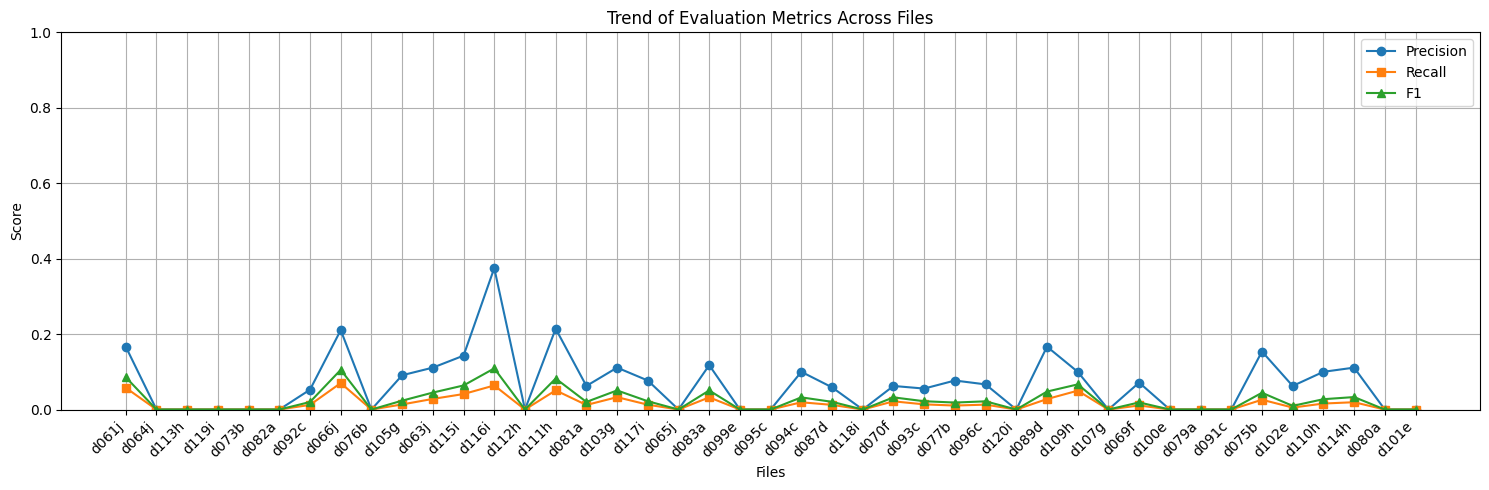

In [11]:
import matplotlib.pyplot as plt

def plot_line_chart(results):
    files = [r['file'] for r in results]
    precision = [r['precision'] for r in results]
    recall = [r['recall'] for r in results]
    f1 = [r['f1'] for r in results]

    plt.figure(figsize=(15, 5))
    plt.plot(files, precision, marker='o', label='Precision')
    plt.plot(files, recall, marker='s', label='Recall')
    plt.plot(files, f1, marker='^', label='F1')

    plt.xlabel('Files')
    plt.ylabel('Score')
    plt.title('Trend of Evaluation Metrics Across Files')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_line_chart(all_results)